# Machine Learning Project

## ---Gender Prediction Model with Neutral Network VGG19---

## Team : Yukun,Jiang & Yuhao, Ding & Junming, Cui

Note: to run our code, you need to download Haar Cascade Classifiers, because we used it to crop the face out of the image during testing phase. (Our training data is pre-croped so there is no need.)

The classifier can be downloaded: https://github.com/opencv/opencv/tree/master/data/haarcascades

We used the front face one.

# Code

In [0]:
# You can get and retrieve data by these commands:
# Cited from the official website
# In our project we only use Wiki dataset due to size limitations
"""
mkdir -p data
cd data

if [ ! -f imdb_crop.tar ]; then
    wget https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/imdb_crop.tar
fi

if [ ! -d imdb_crop ]; then
    tar xf imdb_crop.tar
fi

if [ ! -f wiki_crop.tar ]; then
    wget https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/wiki_crop.tar
fi

if [ ! -d wiki_crop ]; then
    tar xf wiki_crop.tar
fi
"""

In [0]:
from IPython.display import Image

### Retrieving data

In [0]:
"""
This part oof code is used for retrieving data from the downloaded folder.
This code is cited and altered for our purposes from a Keras Implementation using the same dataset released under the MIT license.
https://github.com/yu4u/age-gender-estimation/blob/master/create_db.py
We use this fraction of code because it nicely read out the data.
Particularly, we noticed that it:
1) clear out problemtic data, 
2) put the labels we need to use directly under ,mat file, 
3) Serially number the data

In our implementation, there are many unneccesary features, 
but we just left them there unused just in case bugs occur in deletion process.
"""

import numpy as np
import cv2
import scipy.io
import argparse
from tqdm import tqdm
from scipy.io import loadmat
from datetime import datetime
from IPython.display import Image
import os

def get_meta(mat_path, db):
    meta = loadmat(mat_path)
    full_path = meta[db][0, 0]["full_path"][0]
    dob = meta[db][0, 0]["dob"][0]  # Matlab serial date number
    gender = meta[db][0, 0]["gender"][0]
    photo_taken = meta[db][0, 0]["photo_taken"][0]  # year
    face_score = meta[db][0, 0]["face_score"][0]
    second_face_score = meta[db][0, 0]["second_face_score"][0]

    return full_path, dob, gender, photo_taken, face_score, second_face_score


def mk_dir(dir):
    try:
        os.mkdir( dir )
    except OSError:
        pass

def get_args():
    parser = argparse.ArgumentParser(description="This script cleans-up noisy labels "
                                                 "and creates database for training.",
                                     formatter_class=argparse.ArgumentDefaultsHelpFormatter)
    parser.add_argument("--output", "-o", type=str, required=True,
                        help="path to output database mat file")
    parser.add_argument("--db", type=str, default="wiki",
                        help="dataset; wiki or imdb")
    parser.add_argument("--img_size", type=int, default=32,
                        help="output image size")
    parser.add_argument("--min_score", type=float, default=1.0,
                        help="minimum face_score")
    args = parser.parse_args()
    return args


def main():
    args = get_args()
    output_path = args.output
    db = args.db
    img_size = args.img_size
    min_score = args.min_score

    root_path = "data/{}_crop/".format(db)
    mat_path = root_path + "{}.mat".format(db)
    full_path, dob, gender, photo_taken, face_score, second_face_score = get_meta(mat_path, db)

    out_genders = []
    sample_num = len(face_score)
    out_imgs = np.empty((sample_num, img_size, img_size, 3), dtype=np.uint8)
    valid_sample_num = 0

    for i in tqdm(range(sample_num)):
        if face_score[i] < min_score:
            continue

        if (~np.isnan(second_face_score[i])) and second_face_score[i] > 0.0:
            continue

        if np.isnan(gender[i]):
            continue

        out_genders.append(int(gender[i]))
        img = cv2.imread(root_path + str(full_path[i][0]))
        out_imgs[valid_sample_num] = cv2.resize(img, (img_size, img_size))
        valid_sample_num += 1

    output = {"image": out_imgs[:valid_sample_num], "gender": np.array(out_genders),
              "db": db, "img_size": img_size, "min_score": min_score}
    scipy.io.savemat(output_path, output)


if __name__ == '__main__':
    main()

### Data Preprocessing, spliting

In [0]:
# -*- coding: utf-8 -*-
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
import torchvision.models as model
import numpy as np
import os
from torch.autograd import Variable
import matplotlib.pyplot as plt
import cv2
import pandas as pd
from scipy.io import loadmat
from PIL import Image

# Load preprocessed image
x = loadmat('imdb_db.mat')
image = x['image']
label = x['gender'][0]

#Transformation
trans = [
        transforms.TenCrop(28),
        transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])),
                     ]
trans = transforms.Compose(trans)

# X and y created here
x = []
y = []

# Do transformation here
for i in range(len(image)):
    image_tensor = trans(transforms.ToPILImage()(image[i]))
    for img in image_tensor:
        x.append(img)
        y.append(label[i])

# Split training and validation data, the first 30000 are for training, the others for validation
train_data = []
validation_data = []

for i in range(len(x)):
    if i <= 30000:
        train_data.append([x[i], y[i]])
    else:
        validation_data.append([x[i], y[i]])

#Use dataloader to load the data

trainloader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
validationloader = torch.utils.data.DataLoader(validation_data, batch_size=32, shuffle=True)

### Training and Validation

In [0]:


# Import model, use pretrained
from torchvision import models
model = model.vgg19(pretrained=True)

# Freeze parameters
for param in model.parameters():
    param.requires_grad = False

#Set up our own layers
import torch.nn as nn
model.classifier = nn.Sequential(
        nn.Linear(25088, 4096),
        nn.ReLU(True),
        nn.Dropout(),
        nn.Linear(4096, 4096),
        nn.ReLU(True),
        nn.Dropout(),
        nn.Linear(4096, 2),
    )


# Use crossentropy loss, and optimizer using SGD with momentum = 0.9, and weight decay
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)

# The following training code is cited from https://towardsdatascience.com/transfer-learning-with-convolutional-neural-networks-in-pytorch-dd09190245ce
# We made some alternations to fit our need.   
def train(model,
          criterion,
          optimizer,
          train_loader,
          valid_loader,
          save_file_name,
          max_epochs_stop=3,
          n_epochs=20,
          print_every=2):
    """Train a PyTorch Model

    Params
    --------
        model (PyTorch model): cnn to train
        criterion (PyTorch loss): objective to minimize
        optimizer (PyTorch optimizier): optimizer to compute gradients of model parameters
        train_loader (PyTorch dataloader): training dataloader to iterate through
        valid_loader (PyTorch dataloader): validation dataloader used for early stopping
        save_file_name (str ending in '.pt'): file path to save the model state dict
        max_epochs_stop (int): maximum number of epochs with no improvement in validation loss for early stopping
        n_epochs (int): maximum number of training epochs
        print_every (int): frequency of epochs to print training stats

    Returns
    --------
        model (PyTorch model): trained cnn with best weights
        history (DataFrame): history of train and validation loss and accuracy
    """
    train_on_gpu = False

    # Early stopping intialization
    epochs_no_improve = 0
    valid_loss_min = np.Inf

    valid_max_acc = 0
    history = []

    # Number of epochs already trained (if using loaded in model weights)
    try:
        print(f'Model has been trained for: {model.epochs} epochs.\n')
    except:
        model.epochs = 0
        print(f'Starting Training from Scratch.\n')


    # Main loop
    for epoch in range(n_epochs):

        # keep track of training and validation loss each epoch
        train_loss = 0.0
        valid_loss = 0.0

        train_acc = 0
        valid_acc = 0

        # Set to training
        model.train()

        # Training loop
        for ii, (data, target) in enumerate(train_loader):
            # Tensors to gpu
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
            target = target.long()
            # Clear gradients
            optimizer.zero_grad()
            # Predicted outputs are log probabilities
            output = model(data)

            # Loss and backpropagation of gradients
            loss = criterion(output, target)
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Track train loss by multiplying average loss by number of examples in batch
            train_loss += loss.item() * data.size(0)

            # Calculate accuracy by finding max log probability
            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(target.data.view_as(pred))
            # Need to convert correct tensor from int to float to average
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            # Multiply average accuracy times the number of examples in batch
            train_acc += accuracy.item() * data.size(0)

            # Track training progress
            print(
                f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. ',
                end='\r')

        # After training loops ends, start validation
        else:
            model.epochs += 1

            # Don't need to keep track of gradients
            with torch.no_grad():
                # Set to evaluation mode
                model.eval()

                # Validation loop
                for data, target in valid_loader:
                    # Tensors to gpu
                    if train_on_gpu:
                        data, target = data.cuda(), target.cuda()
                    target = target.long()
                    # Forward pass
                    output = model(data)

                    # Validation loss
                    loss = criterion(output, target)
                    # Multiply average loss times the number of examples in batch
                    valid_loss += loss.item() * data.size(0)

                    # Calculate validation accuracy
                    _, pred = torch.max(output, dim=1)
                    correct_tensor = pred.eq(target.data.view_as(pred))
                    accuracy = torch.mean(
                        correct_tensor.type(torch.FloatTensor))
                    # Multiply average accuracy times the number of examples
                    valid_acc += accuracy.item() * data.size(0)

                # Calculate average losses
                train_loss = train_loss / len(train_loader.dataset)
                valid_loss = valid_loss / len(valid_loader.dataset)

                # Calculate average accuracy
                train_acc = train_acc / len(train_loader.dataset)
                valid_acc = valid_acc / len(valid_loader.dataset)

                history.append([train_loss, valid_loss, train_acc, valid_acc])

                # Print training and validation results
                if (epoch + 1) % print_every == 0:
                    print(
                        f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}'
                    )
                    print(
                        f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%'
                    )

                # Save the model if validation loss decreases
                if valid_loss < valid_loss_min:
                    # Save model
                    torch.save(model.state_dict(), save_file_name)
                    # Track improvement
                    epochs_no_improve = 0
                    valid_loss_min = valid_loss
                    valid_best_acc = valid_acc
                    best_epoch = epoch

                # Otherwise increment count of epochs with no improvement
                else:
                    epochs_no_improve += 1
                    # Trigger early stopping
                    if epochs_no_improve >= max_epochs_stop:
                        print(
                            f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
                        )


                        # Load the best state dict
                        model.load_state_dict(torch.load(save_file_name))
                        # Attach the optimizer
                        model.optimizer = optimizer

                        # Format history
                        history = pd.DataFrame(
                            history,
                            columns=[
                                'train_loss', 'valid_loss', 'train_acc',
                                'valid_acc'
                            ])
                        return model, history

    # Attach the optimizer
    model.optimizer = optimizer
    # Record overall time and print out stats
    print(
        f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
    )

    # Format history
    history = pd.DataFrame(
        history,
        columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])
    return model, history

model, history = train(
    model,
    criterion,
    optimizer,
    trainloader,
    validationloader,
    "ourmodel.pt",
    max_epochs_stop=5,
    n_epochs=30,
    print_every=2)
# A "ourmodel.pt" will be generated as our model.

### Testing

In [0]:

import copy



gender_list = ['Male', 'Female']

gender_net = model

folder_path = "appa-real-release/test"
video_capture = cv2.VideoCapture(0)

new_df = pd.read_csv("gender_label.csv")
new_df = new_df.set_index("file_name")

excep = 0
right, wrong = 0,0
for data_file in sorted(os.listdir(folder_path)):
    try:
        data = data_file.split('.')
        if len(data) == 2:
            continue
        if data_file[-1] not in ["g"]:
            continue
        print(data_file)
        cap = cv2.imread(folder_path + "/" + data_file)
        
        image = copy.deepcopy(cap)
        
        # Using Cascade Classifier we used
        face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
    
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        #plt.imshow(gray)
        #plt.show()
        faces = face_cascade.detectMultiScale(gray, 1.1, 5)
    
        if(len(faces)>0):
            print("Found {} faces".format(str(len(faces))))
    
        for (x, y, w, h)in faces:
            cv2.rectangle(image, (x, y), (x+w, y+h), (255, 255, 0), 2)
        #plt.imshow(image)
        #plt.show()
    
        #Get Face
        face_img = image[y:y+h, x:x+w].copy()
        
        
        blob = cv2.dnn.blobFromImage(face_img, 1, (227, 227), MODEL_MEAN_VALUES, swapRB=False)
    
        #Predict Gender
        gender_net.setInput(blob)
        gender_preds = gender_net.forward()
        gender = gender_list[gender_preds[0].argmax()]
        print("Gender : " + gender)
    
        if new_df.at[filename, 'gender'] == -1:
            plt.imshow(face_img)
            plt.show()
            a = int(input("label: "))
            if a == "q":
                break
            
            new_df.set_value(filename, 'gender', a)
            new_df.to_csv("gender_label.csv")
            hat = gender_list[a]
        else:
            a = new_df.at[filename,"gender"]
            hat = gender_list[a]
        print("actual", a)
        if hat == gender:
            right += 1
        else:
            wrong += 1
        print(right, wrong, excep)
    except:
        excep += 1
        print(right, wrong, excep)

## 1. Introduction


When we first encounter a person in real-life, our first instinct would be to predict the gender and approximate age of that person, then it would be easier and more efficient to conduct a conversation afterwards. Similarly, predicting the person’s gender and age range is of vital significance for an algorithm in order to better interact with the person. The rise of social platforms and media has increased the need of facial recognition. Yet in most fields, the accuracy of existing models is far from satisfactory and a single mis-prediction could result in tremendous financial loss or security issue.
 
Human’s eyes have long been one of the most fundamental sensors to receive information from the outside world. Particularly when interacting with another person, our brains would first automatically give a rough prediction of their gender and age range. However, such “natural” prediction is a difficult yet important problem for Computer Vision. In this project, our team is interested in how we might use a computer algorithm to predict a person’s gender and age range given clear facial images. Specifically, given a person’s clear facial image, we would like our algorithm to give back the gender prediction (Male or Female) and an approximate age range (e.g. (25-32)). As the automation expanding at an ever-accelerating rate, a good model could greatly contribute to the development of information extraction in facial images.
 
After researching online and reading papers in the area, we found that since the facial images are rather complicated, most of the simple machine learning algorithms discussed in class might not be applicable for the prediction of gender and age. Thus, as suggested in most researches, we propose to use the convolutional neural network as our model for the project. 

We would first crop the pictures containing faces to the same size with faces in the center. Then we would use a portion of the pictures to train our CNN model, and tune the model until it gives satisfactory predictions. We eventually came up with a vgg 19 convolutional neural network trained and tuned properly, which could reach a prediction accuracy of  for our validation set. 
In summary, we have obtained a vgg-19 convolutional neural network that gives approximate 72% accuracy in gender prediction. 


## 2. Related Work

@article{Rothe-IJCV-2016,
  author = {Rasmus Rothe and Radu Timofte and Luc Van Gool},
  title = {Deep expectation of real and apparent age from a single image without facial landmarks},
  journal = {International Journal of Computer Vision (IJCV)},
  year = {2016},
  month = {July}

In this paper, they have developed some efficient CNN architectures for gender and age classification. However, since the paper was published several years ago and did not achieve high accuracy, we would like to make changes to the model using more recent machine learning methods, hoping to increase the accuracy of the model. Our attempts include enlarging the dataset by cropping the same picture from different positions, increasing the depth of the network by using the newest 19-layers convolutional neural network and utilizing momentum and weight decay for quicker convergence and less overfitting.  First, by cropping the same image from different positions, we actually enlarge the dataset, thus cancelling some of the background noise in the image. Secondly, using the newest vgg-19 convolutional neural network would enable the model to give far more precise output. Thirdly, the introduction of momentum avoids wasting loops in the Pathological Curvature in neural networks, making it converges faster. 

## 3.Problem Definition and Algorithm

### 3.1 Task


We want our algorithm to perform the task below:<br>
Input: Pictures with a clear face of any size<br>
Output: Gender prediction (Male or Female)
	
	



### 3.2 Network Architecture

The detailed architure of our network is demonstrated below. In the network, there are three types of layer we use:<br>
* Conv2d: the convolutional layer whose kernel winds with extracted features and helps to give tensor of outputs.<br>
* ReLU: rectified linear unit which is the most commonly used activation function in CNNs. $f(x)=max(0,x).$ A soft version called Softplus function $f(x)=\ln(1+e^x)$<br>
* MaxPool2d: A sample-based discretization process by using a max filter to help reduce dimensionality.<br>

A typical pack of convolutional layers are: Conv2d ---> ReLU ---> MaxPool2d

And in the classifier there are another two types of layer we use:
* Linear: connecting every input features to every output features for preservation of information<br>
* Dropout: with parameter $p=0.5$ we drop 50% of input units.



In [0]:
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace)
    (18): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (19): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (20): ReLU(inplace)
    (21): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (22): ReLU(inplace)
    (23): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (24): ReLU(inplace)
    (25): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (26): ReLU(inplace)
    (27): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (28): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (29): ReLU(inplace)
    (30): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (31): ReLU(inplace)
    (32): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (33): ReLU(inplace)
    (34): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (35): ReLU(inplace)
    (36): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(7, 7))
  (classifier): Sequential(
    (0): Linear(in_features=25088, out_features=4096, bias=True)
    (1): ReLU(inplace)
    (2): Dropout(p=0.5)
    (3): Linear(in_features=4096, out_features=4096, bias=True)
    (4): ReLU(inplace)
    (5): Dropout(p=0.5)
    (6): Linear(in_features=4096, out_features=8, bias=True)
  )
)

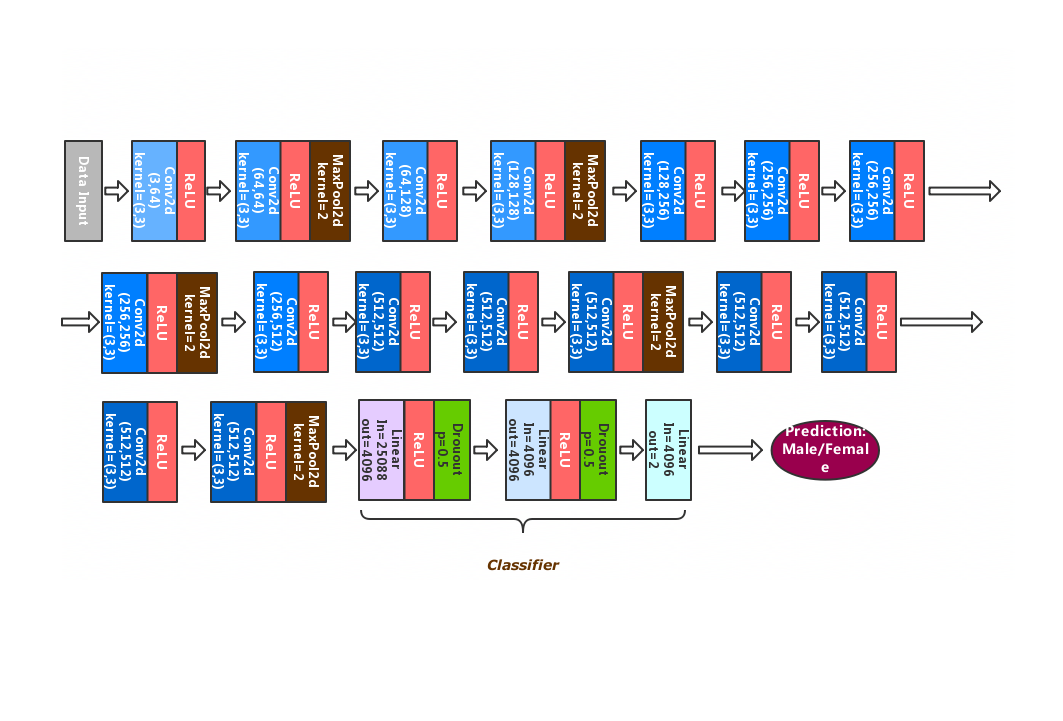

In [0]:
Image(filename="architecture.png",width=750,height=400)

During the training process, we use cross-enropy loss as our loss criteria, and use Adam optimizer with mementum and weight decay as optimizers. 

* Momentum: 

In our convolutional neural network model, we use gradient descent optimization algorithm to minimize the error function to reach a global minima. However, error surfaces are complex in the problem for gender classification, and may more resemble the situation where there are numerous local minima, and the gradient is trapped in one such minimum. Progress here is only possible by climbing higher before descending to the global minimum. So after searching and learning, we decided to use the momentum term to avoid such a situation.
With momentum m, the weight update at a given time t becomes<br>
$$
\Delta w_{ij}(t)=\mu_{i}\delta_{i}y_{i} + m\Delta w_{ij}(t-1)
$$

  
where 0 < m < 1 is the parameter Momentum which adds a fraction of the previous weight update to the current one. When the gradient keeps pointing in the same direction, this will increase the size of the steps taken towards the minimum.

* Weight decay: 

When training our neural networks, we would like to prevent the weights from growing too large, since large weights may lead to overfitting. Therefore, we learned to use the “weight decay” method, in which after each update, the weights are multiplied by a factor slightly less than 1.

During the validation process, if the validation error doesm't change for three loops, the algorithm automatically do early stopping. Also, the model will be saved with the best validation error.

Here below is simple pseudo-code for the training Process:


In [0]:
def PseudoCode(): 
    # Early stopping details
    n_epochs_stop = 5
    min_val_loss = np.Inf
    epochs_no_improve = 0

    # Main loop
    for epoch in range(n_epochs):
    # Initialize validation loss for epoch
    val_loss = 0
    
    # Training loop
    for data, targets in trainloader:
        # Generate predictions
        out = model(data)
        # Calculate loss
        loss = criterion(out, targets)
        # Backpropagation
        loss.backward()
        # Update model parameters
        optimizer.step()
        
    # Validation loop
    for data, targets in validloader:
    # Generate predictions 
    out = model(data)
    # Calculate loss
    loss = criterion(out, targets)
    val_loss += loss

    # Average validation loss
    val_loss = val_loss / len(trainloader)

    # If the validation loss is at a minimum
    if val_loss < min_val_loss:
    # Save the model
    torch.save(model, checkpoint_path)
    epochs_no_improve = 0
    min_val_loss = val_loss
    
    else:
    epochs_no_improve += 1
    # Check early stopping condition
    if epochs_no_improve == n_epochs_stop:
        print('Early stopping!')
        
        # Load in the best model
        model = torch.load(checkpoint_path)

## 4.1 Data Description

* For training data, we are using the dataset extracted from IMDB-WIKI, consisting of roughly 38000 clear facial images, each labelled with gender and age. Then before we proceed to training, we do data pre-processing to strengthen the clarity of the image and thus the robustness of our model. The data pre-processing procedure will be detailedly explained in next section.

* For testing data, we choose to use another dataset from APPA-REAL DATABASE. One thing in particular, this test dataset does not come with gender labels. So in order to test our gender-prediction model, our team (3 people) each manually label the gender feature of this test dataset(around 2000 images). Our manual label error range would be around 5\%
* Here are the sizes of our dataset:<br>
    30000 train data<br>
    8000 valid data<br>
    2000 test data <br>

## 4.2 Data Pre-Processing

A careful inspection into the dataset gives the following features of the images:
* the face in the images might not be exactly located in the center i.e. there are a lot of noises in the images.
* the images are subject to different light condtions and people's skin colors.

To solve the above problems, we experiment and finally use the following data cleaning and preprocessing methods:

* First, we utilize "Haar Cascade classifier" to detect faces in the image, and then crop the faces out. This method will also ensure that the image fed into the network is square-sized. Then we resize the image to (32 * 32), which is a bit larger than the required appropriate size of the input of the neural network (28 * 28).

* Second, we would like to do a Ten-Crop on the image. We use a (28 * 28) frame to place on top left, top rigt, center, bottom left and bottom right to crop our the images. Then we will perform a horizontal flip on the image and implement the same procedures above again. In total we will have 10 copies of a single image and we put these 10 cropped-out images into dataset. This method will ensure biases that come from un-centered faces could be alleviated, for instance when someone is looking at a different angle or the front of face is not facing the camera. We believe such data pre-processing procedure would greatly increase the accuracy of our prediction model.

Here below is a vivid example of how we process an image:

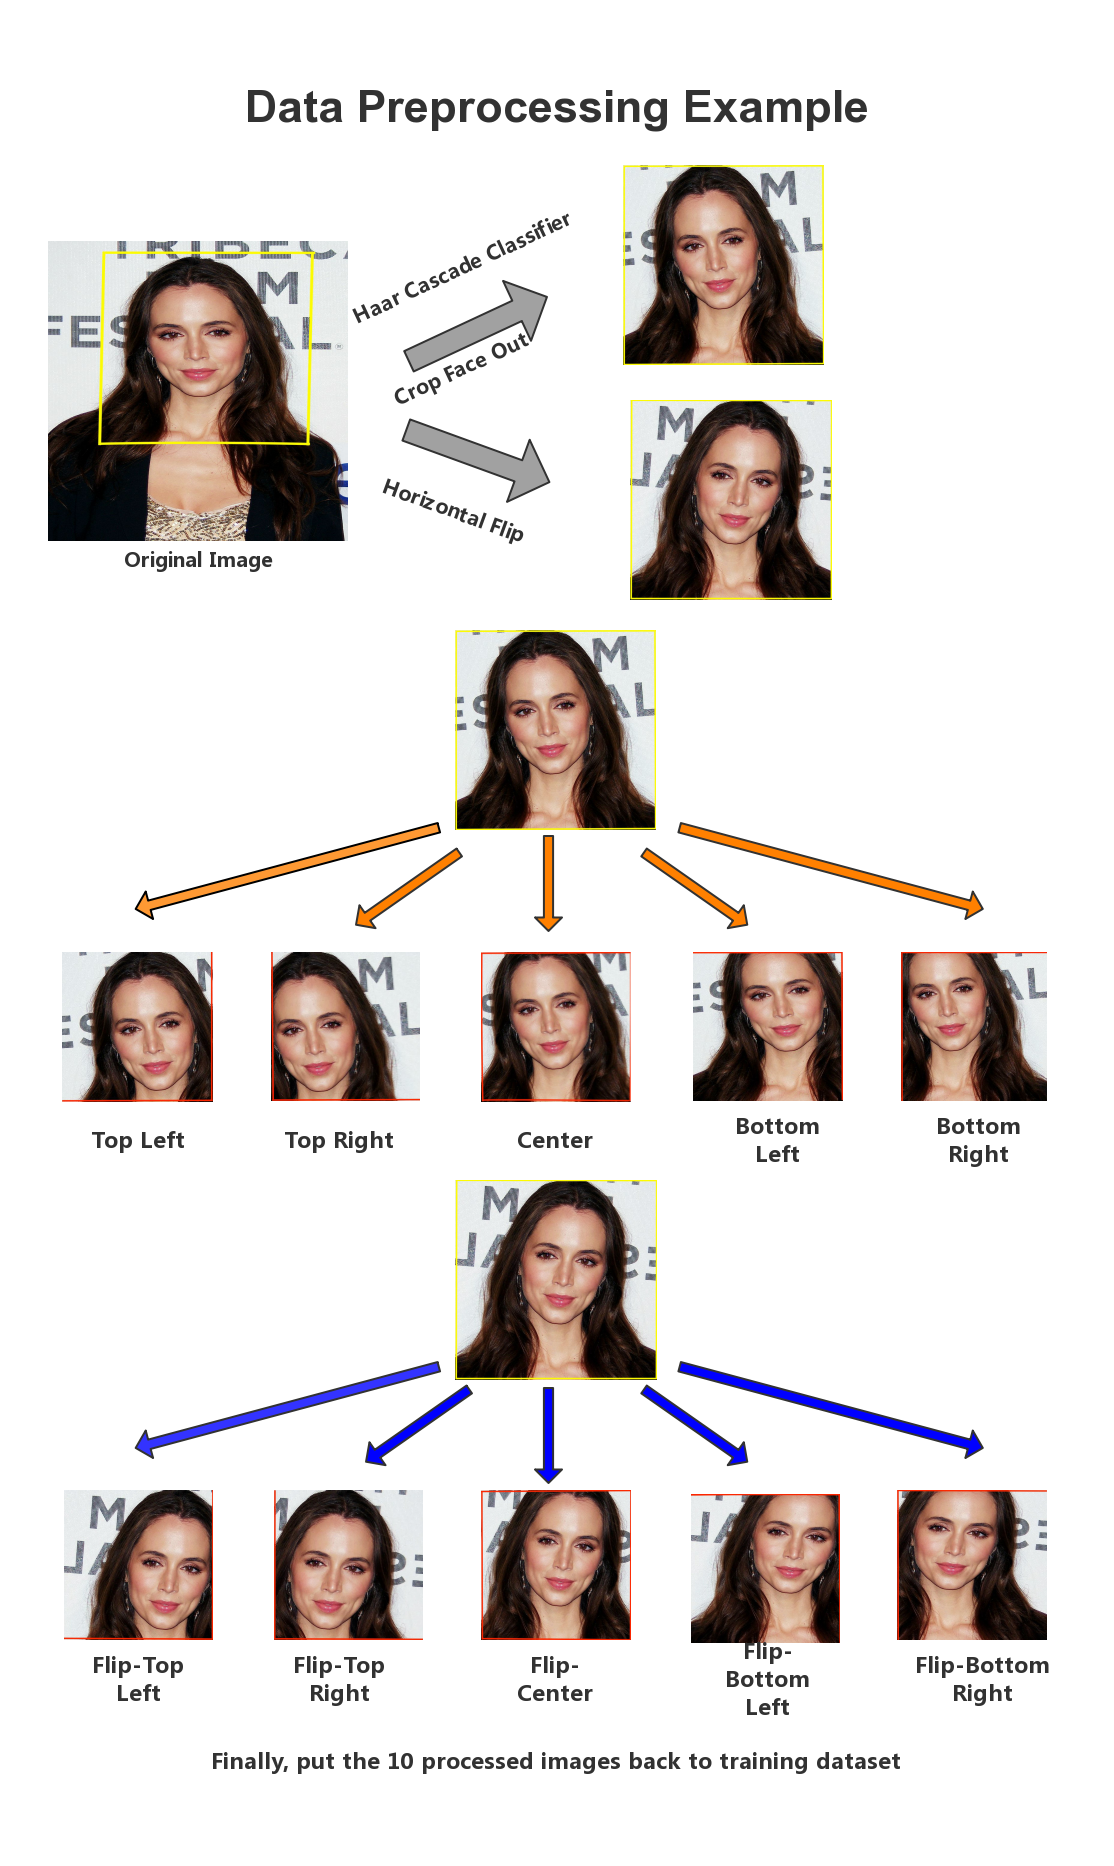

In [0]:
Image(filename="data-preprocessing.png",width=700,height=1000)

## 4.3 Methodology

We propose to use the vgg-19 Convolutional Neural Network as our experimental methodology as explained in 3.2. We will evaluate our methodology based on three main criteria: the prediction accuracy, the robustness to noisy training data, and the computational power required. Ideally, we would like our methodology to be highly accurate in predicting gender, robust to noisy training data, and only requires a modest amount of computational power.  

From the IMDB-WIKI dataset, we randomly downloaded 38123 labelled images, and split them into 30000 training images and 8123 validation images. Since the images in IMDB-WIKI dataset is randomly distributed, we assert with confidence that the training and validation sets are randomly selected. Furthermore, we downloaded 2000 images from the APPA-REAL dataset as testing set, and manually labeled them by male or female. The reason why we did not use images from IMDB-WIKI dataset for testing is that the faces in IMDB-WIKI dataset are mostly celebrities in their middle age, with a significant lack of people under 20 or above 50. By choosing testing images from APPA-REAL set, we can better test the performance of our algorithm for all age groups.


We have trained our model with 2500 labeled images and tested on 500 images. To implement the neural networks, we are using TensorFlow Framework and Keras Deep Learning Open Source Library. Firstly, we train the model using the dataset images. This is a time taking process. During this training part, a model for identifying gender and detecting faces is created, if not already existing, otherwise the previous model is enhanced using backtracking. Then the model details are saved in a separate file. We use this file for testing our model so that we won't have to train the model every time we test it.
During testing period, the image is passed as input to the code. And the image is converted to Monotone mode from color mode for better face detection. This image is passed to the face detector which returns the cropped image centered around the face. The cropped face is then input to the convolutional neural network which classifies the face as a male or a female face. 



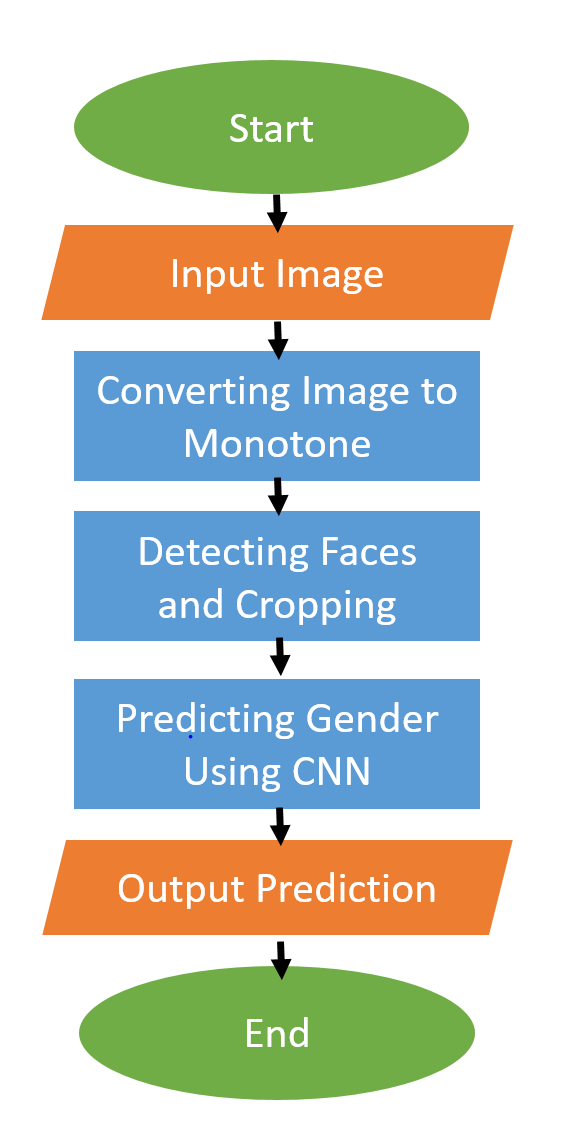

In [0]:
Image(filename="flow chart.PNG",width=200,height=400)

Other models can be used for gender classification are:
1. The K-Nearest Neighbor (KNN) classifier is one of the most heavily usage and benchmark in classification. The k-NN algorithm classifies unknown data points by finding the most common class among the k-closest examples. By literacy review, we found that the advantages of KNN algorithm are: robust to noisy training data, and pretty accurate when the dataset is large. However, to use KNN we need to determine the parameter K (number of interest neighbors), and we don’t know which type of distance to use and which attribute to use for best results. Plus KNN requires very high computational power since we need to compute the distances from every sample to all k-training samples around it, thus we will not use KNNmodel for our project.

2. SVM with Local Binary Patterns (LBP) 
Emon Kumar Dey, Mohsin Khan & Md Haider Ali “Computer Vision-Based Gender Detection from Facial Image” presented at International Journal of Advanced Computer Science. Vol. 3, No. 8, Aug 201
Emon et al. proposed a method in which they used Support Vector Machine(SVM) for gender classification based on facial images. The use of Nonlinear Support Vector Machines (SVMs) are investigated for appearance-based gender classification with low resolution “thumbnail” faces processed from 1,755 images from the FERET face database. The performance of SVMs is shown to remain unsatisfactory at 78.91%. Since the accuracy is so low even when the model is particularly tuned in the same dataset, we will not consider SVM for our project.


Lemley, Sami Abdul-Wahid, Dipayan Banik, Razvan Andonie “Comparison of Recent Machine Learning Techniques for Gender Recognition from Facial Images” presented at MAICS 2016 

After careful research and scrutiny, we have found that Convolutional Neural Network to be the most promising model for gender and age prediction. In papers by Lemley et al., CNN produces a lot better results than any of the previous methods currently in use with an error margin of 0.5% using FERET dataset.



## 4.4 Results

Below is the graph of how model accuracy improves as training epoch increases on both training dataset and validation dataset. We could see at beginning both accuracy on training and validation dataset increase as training epoch increases. Yet after 12~13 epochs, the validation accuracy stays more or less the same. This is an indicator that the model might be prone to over-fitting. So we do early-stopping after 13 epoches.

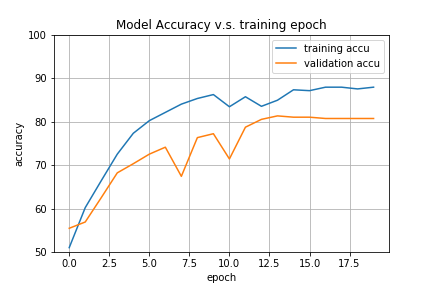

In [0]:
Image(filename="Testresult.png",width=500,height=400)

After we tune our prediction model from training, we test the model on the dataset "appa_real_release" with manually labelled gender labels, which consists of around 1200 male images and 700 female images. We get:
* Prediction right= 1475
* Prediction wrong= 491
* Total Accuracy=$\frac{1475}{1475+491}$=75.02 %


To be more specific, we also calculate the Confusion Matrix for the testing. During the testing, Among the 1288 True Male images, we correctly classify 883 as Male and misclassify 405 as Female. Among the True 678 Female images, we correctly classify 542 as Female and misclassify 136 as Male.

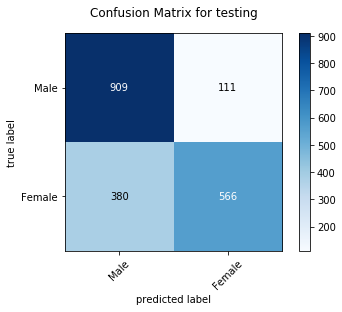

In [0]:
Image(filename="Confusion.png",width=450,height=400)

## 4.5 Discussion

From the results above, there are two points worth discussing:<br>
* Compared with validation accuracy, the test accuracy drops by around 6%. This can be explained in term of difference of the quality and homogeneity of our validation and testing data. On one hand, the validation data is split out from the training data from "IMDB-WIKI", which is composed mostly of Male and female film celebrities in their prime. On the other hand, the testing data from "APPLE_REAL" contains people from all walks of life. In particular, it contains a lot images of children and the elder, whose gender features might not have been well learned during the training process in our model.<br>
* From the Confusion Matrix, we find that the model is around 4 times more likely to misclassify a Female as a Male than misclassify a Male as a Female (406 v.s. 136). This means the model is pretty inaccurate in predicting the gender of a Female. By a careful inspection into our training dataset, we find that while the images of Male celebrities are quite diversified, the images of Female celebrities are actually rigid and homogeneous. Then when we move to the testing dataset which contains all kinds of inhomogeneous Male & Female images, the particular celebritiy-female features do not fully apply. The followings are a few typical mis-classfied example:<br>


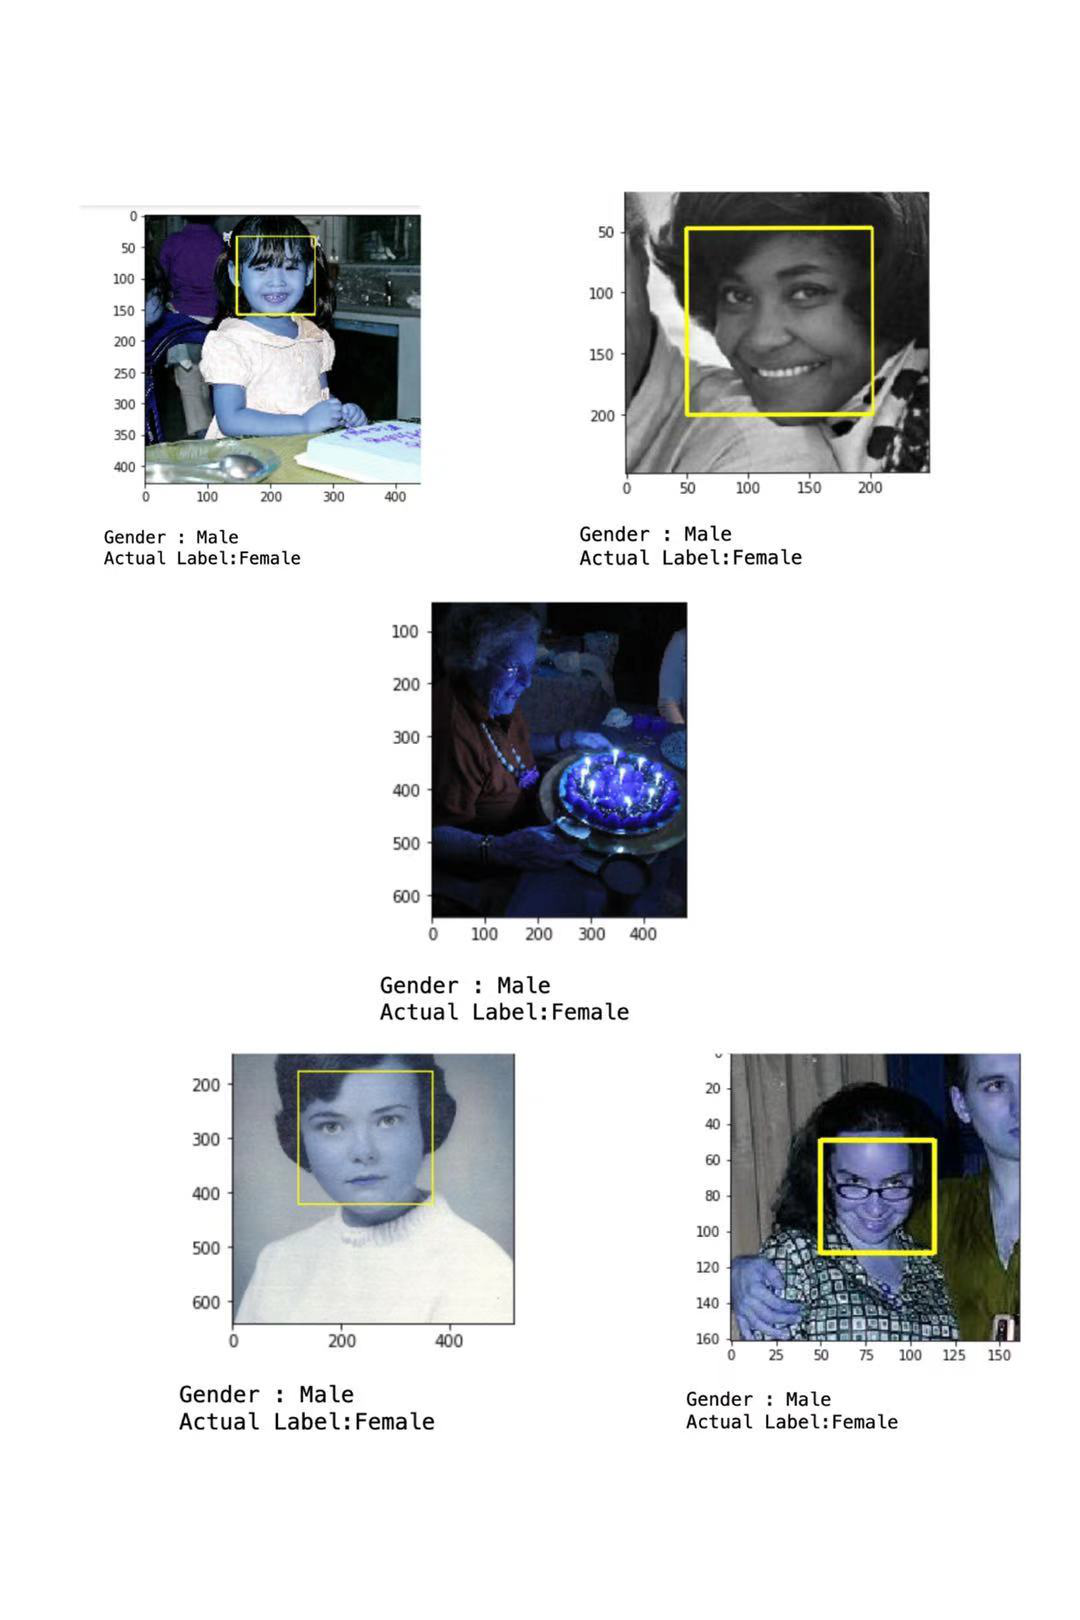

In [0]:
Image(filename="Failure.png",width=700,height=800)

## 5 Conclusions

In our project, we trained a network that could improve computer's perception of gender based on facial image. For computation efficiency, we utilize a pre-trained VGG 19 network, and only train the final classificaiton layer. This method, though saving us from a lot of time required for training, will affect model accuracy.

We realized that convolutional neural network is working properly even with substantial noises inside the dataset. In both our training and testing process, we use internet images rather than lab images, this leaves room for great image noises. In our project we used too few training data, thus the accuracy isn't good, however, given enough training data, the network have shown its capability of dealing with noises.

In our testing set, we deliberatedly choose data that cover a variety of ages, and it shows that the model isn't predicting well in some age groups, especially the elder and babies. Also, skin colors might be another factor. We think that these can be solved by a more concrete training set with less biases.

There are some things we can consider to improve:
* Models can be fully trained with better computational power. Possibly with more parameters tried.
* Data can be processed with other techniques. One such technique as we have seen in other projects is mix-up, which mix up both training images and labels by linear interpolation.

 $x = \lambda * x1 + (1 - \lambda) * x2$, 

 $y = \lambda * y1 + (1 - \lambda) * y2$.

 Other data augmentation methods can also be used.
* The VGG19 network we used, is already a very deep neural network, but our data fed inside is 28*28, we think that the image size is too small, if we can have access to potentially bigger facial image, possibly more features can be used in the training process.
